# 02_IDAO_EDA_one_satellite

* обзор данных, полученных от одного из спутников

## Данные

* id — integer measurement id
* epoch — datetime in "%Y-%m-%dT%H:%M:%S.%f” format (like 2014-02-01T00:44:57.685)
* sat_id — integer satellite id
* x, y, z, x_sim, y_sim, z_sim — real (obtained with the precise simulator) and simulated (obtained with SGP4-simulator) coordinates of the satellite (km)
* Vx, Vy, Vz, Vx_sim, Vy_sim, Vz_sim — real (obtained with the precise simulator) and simulated (obtained with SGP4-simulator) velocities of the satellite (km/s)

## 0. Подключение библиотек

In [20]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

import seaborn as sns; sns.set()

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

## 1. Обзор данных

In [21]:
# Тренировочные данные
df_train = pd.read_csv('data/train_proc.csv', index_col='datetime', parse_dates=True)
df_test = pd.read_csv('data/Track 1/test_proc.csv', index_col='datetime', parse_dates=True)

# Задача 1
submission = pd.read_csv('data/Track 1/submission.csv')

df_train = df_train.drop(['Unnamed: 0'], axis=1)
df_test = df_test.drop(['Unnamed: 0'], axis=1)

In [22]:
df_train.head(3)

,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
datetime,,,,,,,,,,,,,
2014-01-01 00:00:00,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
2014-01-01 00:46:43,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2014-01-01 01:33:26,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768


In [23]:
df_test.head(3)

,sat_id,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
datetime,,,,,,,
2014-02-01 00:01:45,1,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
2014-02-01 00:22:57,1,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402
2014-02-01 00:44:08,1,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412


## 2. Анализ поведения одного из спутников

Выберем спутник 7:

In [24]:
df_for_graph = df_train.query('sat_id == 7')

In [25]:
df_for_graph = df_for_graph.drop(['sat_id'], axis=1)

### 2.1 Распределение признаков

In [26]:
df_for_graph.describe()

,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
count,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000
mean,-69315.624667,46887.014066,35316.506422,-0.033309,0.030279,0.023446,-68866.545944,47886.280659,36141.644666,-0.045066,0.018003,0.011998
std,54817.363085,39881.169942,33737.494500,1.496511,1.115243,0.952355,54478.594892,39801.439500,33573.961301,1.465762,1.122481,0.951489
min,-130892.958010,-30383.329061,-28134.533429,-1.620949,-1.078845,-0.848142,-129288.804728,-30102.878107,-27280.696713,-1.589777,-1.093212,-0.856612
25%,-119053.574244,13142.376824,11261.362224,-1.293535,-0.847742,-0.695181,-120101.579505,18241.969393,11191.359709,-1.276861,-0.818671,-0.702429
50%,-86632.156929,58839.309849,45541.196088,-0.460948,-0.305129,-0.325002,-87375.770287,62461.888698,45560.564402,-0.453640,-0.313477,-0.328873
75%,-27073.403355,83191.252703,67901.830262,0.591825,0.580501,0.393743,-24426.265194,83833.790630,68260.847086,0.614513,0.558539,0.378398
max,36914.092311,91768.121957,73966.090302,3.684464,3.037405,2.658491,36657.721553,92497.580940,74442.446965,3.746550,2.825322,2.509000


### 2.2 Корреляция признаков

In [27]:
df_for_graph.corr()

,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
x,1.000000,-0.221832,-0.106465,0.014984,0.914631,0.925932,0.919591,0.103791,0.213010,-0.310376,0.863772,0.839014
y,-0.221832,1.000000,0.993122,-0.907022,-0.037465,-0.142845,-0.497131,0.909293,0.866010,-0.729930,-0.336088,-0.420831
z,-0.106465,0.993122,1.000000,-0.923108,0.071263,-0.034839,-0.398117,0.940626,0.909489,-0.781994,-0.240559,-0.330025
Vx,0.014984,-0.907022,-0.923108,1.000000,-0.145360,-0.031052,0.317527,-0.849587,-0.826175,0.774192,0.251738,0.340352
Vy,0.914631,-0.037465,0.071263,-0.145360,1.000000,0.993377,0.755161,0.285823,0.378695,-0.517972,0.800733,0.751729
Vz,0.925932,-0.142845,-0.034839,-0.031052,0.993377,1.000000,0.800349,0.191930,0.288592,-0.435893,0.838563,0.799118
x_sim,0.919591,-0.497131,-0.398117,0.317527,0.755161,0.800349,1.000000,-0.206010,-0.093143,-0.005360,0.912810,0.923477
y_sim,0.103791,0.909293,0.940626,-0.849587,0.285823,0.191930,-0.206010,1.000000,0.993460,-0.908662,-0.022481,-0.123021
z_sim,0.213010,0.866010,0.909489,-0.826175,0.378695,0.288592,-0.093143,0.993460,1.000000,-0.925089,0.083368,-0.017677
Vx_sim,-0.310376,-0.729930,-0.781994,0.774192,-0.517972,-0.435893,-0.005360,-0.908662,-0.925089,1.000000,-0.163928,-0.055583


In [34]:
df_heatmap = df_for_graph.reset_index()
df_heatmap = df_heatmap.drop(['datetime'], axis=1)

In [36]:
real_values = df_heatmap[['x', 'y', 'z', 'Vx', 'Vy', 'Vz']]
sim_values = df_heatmap[['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']]

### 2.3 Матрица корреляции

Матрица корреляции реальных признаков:

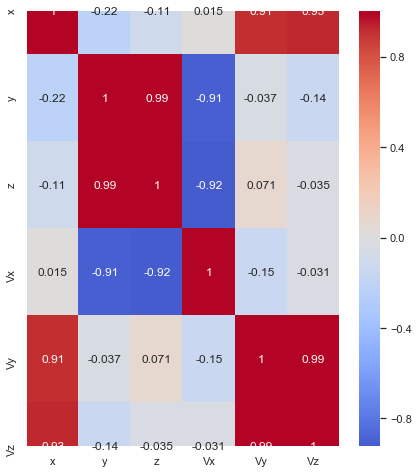

In [31]:
corr_matrix = real_values.corr()
f, ax = plt.subplots(figsize=(7, 8))
sns.heatmap(corr_matrix, center=0, cmap='coolwarm', annot=True, ax=ax)

Матрица корреляции симулированных признаков:

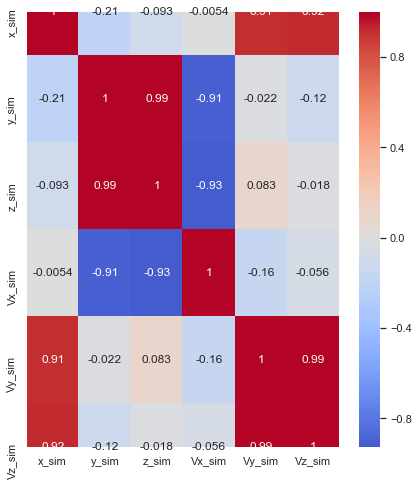

In [32]:
corr_matrix = sim_values.corr()
f, ax = plt.subplots(figsize=(7, 8))
sns.heatmap(corr_matrix, center=0, cmap='coolwarm', annot=True, ax=ax)

### 2.4 Построение графиков

In [37]:
init_notebook_mode(connected = True)
def plotly_df(df, columns = ''):
    data = []
    
    if columns == '':
        columns = df.columns
    
    for column in columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = column)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

### 2.4.1 Общий вид

In [16]:
plotly_df(df_for_graph)

### 2.4.2 Местоположение по оси X

In [38]:
plotly_df(df_for_graph, ['x', 'x_sim'])

### 2.4.3 Местоположение по оси Y

In [18]:
plotly_df(df_for_graph, ['y', 'y_sim'])

### 2.4.4 Местоположение по оси Z

In [19]:
plotly_df(df_for_graph, ['z', 'z_sim'])

### 2.4.5 Скорость по оси X

In [39]:
plotly_df(df_for_graph, ['Vx', 'Vx_sim'])

### 2.4.6 Скорость по оси Y

In [41]:
plotly_df(df_for_graph, ['Vy', 'Vy_sim'])

### 2.4.7 Скорость по оси Z

In [42]:
plotly_df(df_for_graph, ['Vz', 'Vz_sim'])